In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

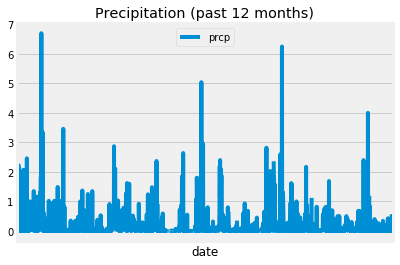

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last date within the dataset
ending_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(ending_date)

# Calculate the date 1 year ago from the last data point in the database
beginning_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print(beginning_date)

# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= beginning_date).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(data_prcp).set_index('date')

# Sort the dataframe by date
prcp_df.sort_values
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax1 = plt.subplots()
prcp_df.plot(title='Precipitation (past 12 months)',ax=ax1)
ax1.get_xaxis().set_ticks([])
ax1.legend(loc='upper center')



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} stations available in this dataset.")

There are 9 stations available in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
print(f"The most active station is {active_stations[0][0]} with {active_stations[0][1]} records")

The most active station is USC00519281 with 2772 records


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print (most_active_temp)


[(54.0, 85.0, 71.66378066378067)]


In [16]:
print(f"Among the most active station's records:\nLowest Temperature: {most_active_temp[0][0]}\nHighest Temperature: {most_active_temp[0][1]}\nAverage Temperature: {most_active_temp[0][2]}")

Among the most active station's records:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


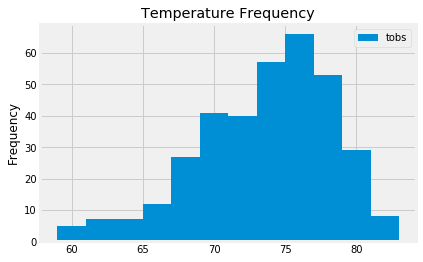

In [18]:
# Choose the station with the highest number of temperature observations
most_temp_station = session.query(Measurement.station, 
                                  func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Query the last 12 months of temperature observation data for this station
most_temp_data = session.query( Measurement.tobs).filter(Measurement.date >= beginning_date).filter(Measurement.station == most_temp_station).all()
temp_df = pd.DataFrame(most_temp_data)

#plot the results as a histogram
fig2, ax2 = plt.subplots()
temp_df.plot(kind="hist",bins=12,ax=ax2, title="Temperature Frequency")


In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [64]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

trip_temp = calc_temps('2017-03-13', '2017-04-20')
print(f"The temperature for my trip is:\nLowest: {trip_temp[0][0]}\nAverage: {trip_temp[0][1]}\nHighest: {trip_temp[0][2]}")

The temperature for my trip is:
Lowest: 65.0
Average: 73.63673469387756
Highest: 83.0


([], <a list of 0 Text xticklabel objects>)

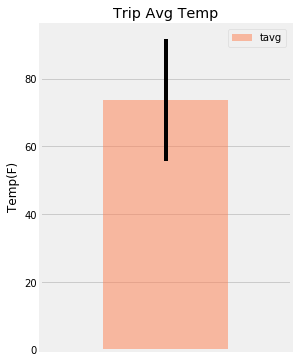

In [65]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Convert trip data into a data frame
trip_temp_df = pd.DataFrame(trip_temp, columns=['tmin', 'tavg', 'tmax'])

fig3, ax3 = plt.subplots()
trip_temp_df.plot(kind="bar",y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), ax=ax3, title='Trip Avg Temp',color='coral', alpha=0.5, figsize=(4,6))

plt.grid(axis='x)
plt.ylabel('Temp(F)'')
plt.xticks(np.arange(1, 1.0))

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def prcp(start_date, end_date):
    
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of precipitation amount, station, name, latitude, longitude, and elevation in descending order pf precipitation amount.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
   
        
trip_prcp=prcp('2017-03-13','2017-04-20')
trip_prcp


[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  None)]